In [113]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import blimpy as bl 
import setigen as stg 
from astropy import units as u
from astropy.coordinates import Angle
import time
import os

%matplotlib inline

In [114]:
carmen_df = pd.read_csv('/home/cgchoza/galaxies/complete_cadences_catalog.csv')
carmen_df['.h5 path'] = carmen_df['.h5 path'].str.replace('0000.h5', '0002.h5', regex=False)
carmen_df = carmen_df.drop_duplicates(subset='.h5 path', keep='first').reset_index(drop=True)
carmen_df = carmen_df[~carmen_df['.h5 path'].str.contains('spliced')].reset_index(drop=True)
carmen_df = carmen_df.drop(index = 17546)

In [115]:
### Load in single-channel Voyager 1 data to compute some GBT noise statistics.
### If you're using a different telescope, you may wish to load a different HDF5 file for waterfall_fn.

waterfall_fn = carmen_df['.h5 path'].iloc[-1]

fb = bl.Waterfall(waterfall_fn)
print(fb.header)

### Perform a sigma-clipping routine to remove the Voyager signal and most of the PFB rolloff.
### (See C. Choza et al 2024 for justification.)
from astropy.stats import sigma_clip
clipped_data = sigma_clip(fb.data,
                                  sigma=3,
                                  maxiters=5,
                                  masked=False)
### Compute the noise floor and rms. We will use the noise floor to initialize our synthetic frame below.
noise_mean = np.mean(clipped_data)
noise_std = np.std(clipped_data)
print(noise_mean)
print(noise_std)
print(noise_std/noise_mean/np.sqrt(1465))

{'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 1126.46484375, 'foff': -0.00286102294921875, 'ibeam': 1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 65536, 'nfpc': 1024, 'nifs': 1, 'rawdatafile': 'guppi_59902_24005_HIP50744_0057.0000.raw', 'source_name': 'HIP50744', 'src_dej': <Angle 21.3908 deg>, 'src_raj': <Angle 10.36250667 hourangle>, 'telescope_id': 6, 'tsamp': 1.073741823999999, 'tstart': 59902.27783564815, 'za_start': 0.0}
740.641
139.55988
0.00492304730969045


In [116]:
### Load in single-channel Voyager 1 data to compute some GBT noise statistics.
### If you're using a different telescope, you may wish to load a different HDF5 file for waterfall_fn.

waterfall_fn = carmen_df['.h5 path'].iloc[20000]

fb = bl.Waterfall(waterfall_fn)
print(fb.header)

### Perform a sigma-clipping routine to remove the Voyager signal and most of the PFB rolloff.
### (See C. Choza et al 2024 for justification.)
from astropy.stats import sigma_clip
clipped_data = sigma_clip(fb.data,
                                  sigma=3,
                                  maxiters=5,
                                  masked=False)
### Compute the noise floor and rms. We will use the noise floor to initialize our synthetic frame below.
noise_mean = np.mean(clipped_data)
noise_std = np.std(clipped_data)
print(noise_mean)
print(noise_std)
print(noise_std/noise_mean/np.sqrt(1465))

{'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 9563.96484375, 'foff': -0.00286102294921875, 'ibeam': -1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 65536, 'nifs': 1, 'rawdatafile': 'guppi_59411_52310_HIP7464_0088.0000.raw', 'source_name': 'HIP7464', 'src_dej': <Angle -6.27172194 deg>, 'src_raj': <Angle 1.60250528 hourangle>, 'telescope_id': 6, 'tsamp': 1.073741823999999, 'tstart': 59411.60543981481, 'za_start': 0.0}
243978.55
26744.094
0.0028638972098974868


In [117]:
### We need our synthetic data to be readable by turboSETI/BLISS, so we will make it into an HDF5 file with BL's usual header style.
### Most of this information is a placeholder with the precise value being unimportant.

head = {'DIMENSION_LABELS': np.array([b'time', b'feed_id', b'frequency'], dtype=object), 
        'az_start': 0.0, 
        'data_type': 1, 
        'fch1': fb.header['fch1'], # This is the edge of a C-band node; it can be changed, but other values below will then also have to be changed.
        'foff': fb.header['foff'], # Fine-channel frequency resolution.
        'machine_id': 20, 
        'nbits': 32, 
        'nchans': 65536*16, # 64 or 16??
        'nifs': 1, 
        'source_name': 'synthetic', # Placeholder name. Some Blimpy functions care about the source name.
        'src_dej': Angle(0*u.deg), # Placeholder declination.
        'src_raj': Angle('0h0m0s'), # Placeholder RA.
        'telescope_id': 6, 
        'tsamp': 1.073741823999999, # Time resolution.
        'tstart': 60000, # Arbitrary epoch of observation.
        'za_start': 0.0}

In [118]:
### In this cell, we generate 16 coarse channels' worth of chi2 noise using the noise mean we computed from the real GBT data above.

### Read in the polyphase filterbank (PFB) shape. 
### If you're using a different telescope, you can generate a custom PFB shape using BLISS.
### Type the following command in the terminal on the Berkeley Data Center to see how:
### bliss_generate_channelizer_response -h
long_data = []
n_fine = 1024
n_tap = 8
output_file = "/datax/scratch/jliang/channelizer_response.f32"

cmd = f"bliss_generate_channelizer_response -M 512 -N 12 -f 1024 -o {output_file}"
os.system(cmd)
pfb = np.fromfile(output_file, dtype='float32')

### Do one coarse channel at a time.
### Setigen frame construction has a nonlinear complexity, so this is faster than doing a single frame with 16 channels.
for i in range(16):

    print(i)

    fchans = 1024
    tchans = 279
    df = abs(fb.header['foff'])*1e6*u.Hz
    dt = fb.header['tsamp']*u.s
    fch1 = 6095.214842353016*u.MHz

    frame = stg.Frame(fchans=fchans,
                    tchans=tchans,
                    df=df,
                    dt=dt,
                    fch1=fch1,
                    chi2_df=2)
    noise = frame.add_noise(x_mean=noise_mean)

    
    pfb_data = np.array([spec*pfb for spec in frame.data])

    long_data.append(pfb_data)

Found a usable device
Found a usable device
Found a usable device
Found a usable device
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [119]:
### Convert your 16-channel numpy array back to a setigen Frame.
### Remember to use the metadata we defined earlier!

frame = stg.Frame.from_data(df = abs(fb.header['foff'])*1e6*u.Hz,
                            dt = fb.header['tsamp']*u.s,
                            fch1 = 6095.214842353016*u.MHz,
                            ascending=False,
                            data=long_data[0], # Use the first coarse channel's data as a template
                            metadata=head)

In [120]:
### Save the 16 channels of noise as an HDF5 file.
### (Replace /datax/scratch/benjb/... with your own scratch directory and filepath.)

frame.save_h5('/datax/scratch/jliang/test.h5')

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/jliang/test.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 0.02sec


In [121]:
### Read the noise file back in as a Waterfall object to check that everything looks right.

fb = bl.Waterfall('/datax/scratch/jliang/test.h5')
fb.info()


--- File Info ---
DIMENSION_LABELS :   ['time' 'feed_id' 'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :            6095.214842353015 MHz
            foff :         -0.00286102294921875 MHz
           ibeam :                               -1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                             1024
            nifs :                                1
     rawdatafile :                        Synthetic
     source_name :                        Synthetic
         src_dej :                     -28:22:59.16
         src_raj :                         17:47:15
    telescope_id :                                6
           tsamp :                1.073741823999999
   tstart (ISOT) :          2018-12-13T17:12:37.000
    tstart (MJD) :               58465.717094

In [122]:
### Now we'll start injecting signals.

### Define here the frequencies at which you want to inject signals.
### I put them 32 kHz apart over the full frequency range, which results in 1465 signals.
### You can put them somewhat closer together than this, but if you cram too many signals into
### the data, it biases the noise calculations of turboSETI and BLISS.
### Leave at least 8 kHz of space between, as a general rule.
center_frequencies = np.arange(6092.288015875964+0.008, 6095.214842353015-0.008, 0.032)

n_inj = len(center_frequencies)
print(n_inj)

### Shuffle around the center frequencies by up to +/-50 Hz; this step isn't necessary with fully synthetic data,
### but in RFI-heavy data it helps you ensure that your injections don't line up with RFI combs with the same frequency intervals.
### (Unlikely but possible.)
cf_offsets = np.random.uniform(-0.00005, 0.00005, n_inj)
center_frequencies = center_frequencies + cf_offsets

fdiffs = np.diff(np.sort(center_frequencies))

### Define range of drift rates (in Hz/s).
drift_rates = np.random.uniform(-1, 1, n_inj)

### Define range of SNRs.
snrs = np.random.uniform(1, 1000, n_inj)

### Define signal widths (all unresolved signals in this case).
widths = np.ones_like(snrs)

print(np.min(fdiffs)*1000000)
print(len(center_frequencies))

91
31910.531298308342
91


In [123]:
### In this cell, we'll do the injections using the parameters we defined in the last cell.

freqs, _ = fb.grab_data()

h5_path = '/datax/scratch/jliang/test.h5'
fb = bl.Waterfall('/datax/scratch/jliang/test.h5')
fb.info()

n_coarse = 16
pfb_corr = np.concatenate([np.fromfile('/datax/scratch/jliang/channelizer_response.f32', dtype='float32') for i in range(n_coarse)])
c = stg.Frame(fb)

intensity = c.get_intensity(snr=1000)

### Loop over all the frequencies — each frequency is a signal.

for i in range(len(center_frequencies)):
    if i%1 == 0:
        print(f'{i} of {len(center_frequencies)}')

    # Retrieve parameters for this signal.
    f = center_frequencies[i]
    d = drift_rates[i]
    w = widths[i]
    s = snrs[i]
    dsign = np.sign(d)

    # Define a bounding box for this signal.
    # The mins and maxes are to account for fch1 sometimes being the leftmost and sometimes the rightmost frequency.

    lb = np.min(((f-dsign*0.03), (f+d*(1e-6)*300+dsign*0.0001)))
    rb = np.max(((f-dsign*0.03), (f+d*(1e-6)*300+dsign*0.0001)))

    ### Noise statistics should be calculated solely from the window of injection, not the whole coarse channel.
    data_window = bl.Waterfall(h5_path, lb, rb)
    subc = stg.Frame(data_window)
    # noise_floor = np.mean(data_window)
    # intensity_diff = noise_mean - noise_floor
    # print(noise_mean)
    # print(noise_floor)
    # print(intensity_diff)
    # print(c.get_intensity(snr=1000))
    #print(f'lb: {lb} rb: {rb}')

    c.add_signal(
    stg.simple_rfi_path(
        f_start=(f * u.MHz),
        drift_rate=d * u.Hz / u.s,
        spread=20 * u.Hz,              # or just 0
        spread_type='uniform',
        rfi_type='random_walk'
    ),
    stg.constant_t_profile(level=subc.get_intensity(snr=s)),
    stg.box_f_profile(width=w * c.df * u.Hz),
    stg.constant_bp_profile(level=1),   # or use your own bp_profile if needed
    doppler_smearing=True,
    smearing_subsamples=15,
    bounding_f_range=(lb * u.MHz, rb * u.MHz)
)

    # c.add_signal(stg.simple_rfi_path(f_start=(f*u.MHz),
    #                            drift_rate=d*u.Hz/u.s,
    #                            spread=0,
    #                            rfi_type='uniform',
    #                        stg.constant_t_profile(level=subc.get_intensity(snr=s)),
    #                        stg.box_f_profile(width=w*c.df*u.Hz),
    #                        pfb_corr[np.argmin(np.abs(freqs-rb)):np.argmin(np.abs(freqs-lb))],
    #                        #stg.constant_bp_profile(level=1),
    #                        #integrate_t_profile=True,
    #                        #integrate_f_profile=True,
    #                        #integrate_path=True,
    #                        doppler_smearing=True,
    #                        smearing_subsamples=15,
    #                        bounding_f_range=(lb*u.MHz, rb*u.MHz)))
    
# Convert the Frame to a numpy array and then to a Waterfall object.
# This lets us stipulate the dtype of the array, which keeps seticore from complaining.

fb_new = bl.Waterfall(filename=None, header_dict=fb.header, data_array=np.expand_dims(np.flip(c.data, axis=1), axis=1).astype('<f4'))

fb_new.write_to_hdf5('/datax/scratch/jliang/test_signal.h5')


--- File Info ---
DIMENSION_LABELS :   ['time' 'feed_id' 'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :            6095.214842353015 MHz
            foff :         -0.00286102294921875 MHz
           ibeam :                               -1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                             1024
            nifs :                                1
     rawdatafile :                        Synthetic
     source_name :                        Synthetic
         src_dej :                     -28:22:59.16
         src_raj :                         17:47:15
    telescope_id :                                6
           tsamp :                1.073741823999999
   tstart (ISOT) :          2018-12-13T17:12:37.000
    tstart (MJD) :               58465.717094

In [124]:
### Don't forget to save the parameters you generated!

np.save('/datax/scratch/jliang/injections.npy', np.array([center_frequencies, drift_rates, snrs, widths]))

In [125]:
print(lb)
print(rb)

6095.175746697289
6095.205988666536


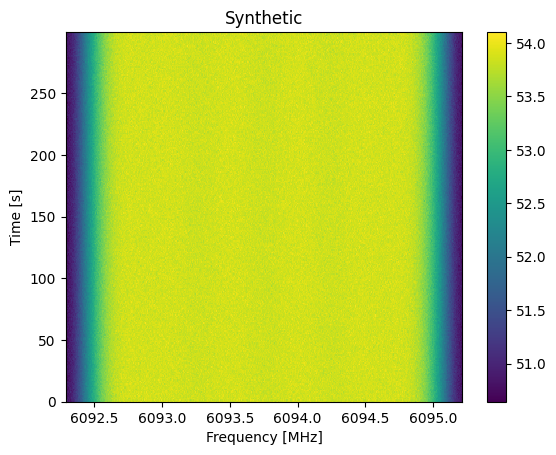

In [126]:
fb = bl.Waterfall('/datax/scratch/jliang/test.h5')
fb.plot_waterfall()

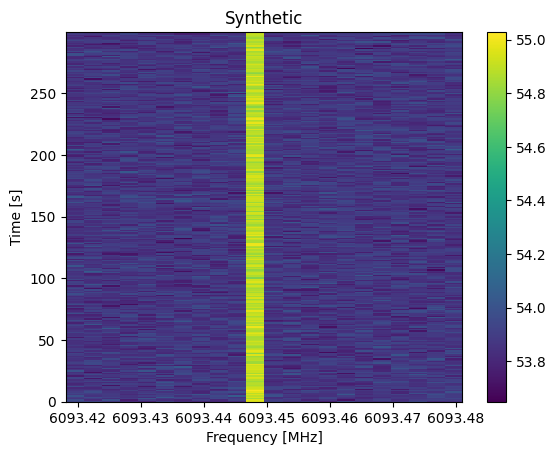

In [127]:
fb = bl.Waterfall('/datax/scratch/jliang/test_signal.h5')
fb.plot_waterfall(f_start=center_frequencies[36]-0.03, f_stop=center_frequencies[36]+0.03)
#fb.plot_waterfall()

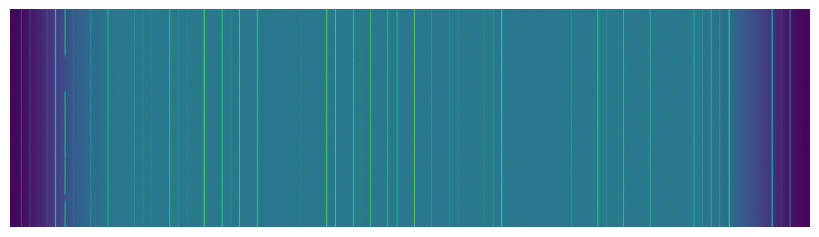

In [128]:
fb = bl.Waterfall('/datax/scratch/jliang/test_signal.h5')
data = fb.data.squeeze()  # shape (time, frequency)

plt.figure(figsize=(8, 8 * data.shape[0] / data.shape[1]), dpi=100)  # keep aspect ratio square per pixel
plt.imshow(data, aspect='auto', cmap='viridis', origin='lower')

plt.axis('off')  # Remove all axes/labels/ticks
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove whitespace

# plt.savefig('waterfall_no_labels_rfi.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [129]:
plt.figure(figsize=(data.shape[1]/100, data.shape[0]/100), dpi=100)
plt.imshow(data, aspect='auto', cmap='viridis', origin='lower')
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig('waterfall_native_rfi.png', bbox_inches='tight', pad_inches=0)
plt.close()

extracting integration 0...


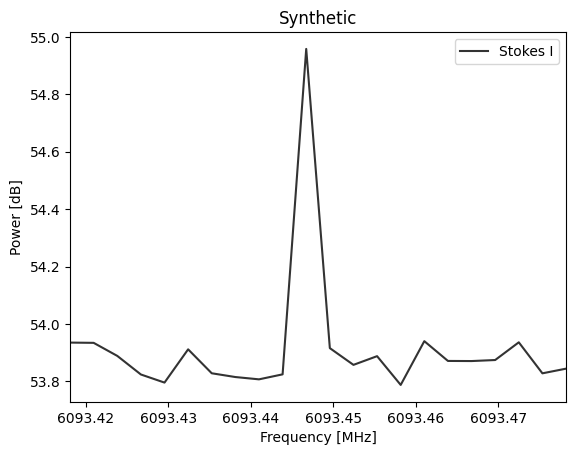

In [130]:
fb.plot_spectrum(logged=True, f_start=center_frequencies[36]-0.03, f_stop=center_frequencies[36]+0.03)
#fb.plot_spectrum(logged=True)

In [131]:
print(center_frequencies)

[6092.29600128 6092.32797084 6092.36000902 6092.39202447 6092.42397725
 6092.4559923  6092.48799154 6092.52001432 6092.55202005 6092.5840462
 6092.61598735 6092.64800535 6092.68005243 6092.71201903 6092.74398379
 6092.77601743 6092.80805622 6092.84005048 6092.87205053 6092.90403923
 6092.93606148 6092.96798198 6093.00004107 6093.03203965 6093.06403769
 6093.09601265 6093.12796606 6093.15996719 6093.1919962  6093.22401311
 6093.25600894 6093.28797308 6093.32003098 6093.35198259 6093.38399031
 6093.41603296 6093.44805771 6093.48000487 6093.51199941 6093.54401609
 6093.57604651 6093.60804057 6093.63997786 6093.67199759 6093.70403503
 6093.73603767 6093.76798072 6093.80001442 6093.83198107 6093.86404273
 6093.89598984 6093.92801609 6093.9600024  6093.99201715 6094.02396889
 6094.05600495 6094.08797017 6094.11997777 6094.15197932 6094.1839963
 6094.21600363 6094.24796675 6094.28004825 6094.311976   6094.34397743
 6094.37600832 6094.40801982 6094.44003087 6094.47205541 6094.50404808
 6094.53

In [132]:
idxs = np.where(np.isclose(center_frequencies, 6093.47998489, atol=1e-6))[0]
print(idxs)

[36 37 38]


In [133]:
print(snrs[36])

349.7487766456369


In [134]:
arr = np.load('/datax/scratch/jliang/test.npy')
df = pd.DataFrame(arr)
df

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,119534.420477,121153.612181,121414.687379,120921.493522,119906.716434,121809.222002,119140.497546,121904.000229,120773.411386,121196.425860,...,121820.634004,121868.000251,120384.001877,123480.767131,124100.288312,120143.256788,123854.255359,120427.092213,119311.333104,120482.189636
1,120680.936159,122390.932473,119610.051559,119593.675888,123623.917196,121150.150193,123345.134988,122492.239632,121449.252631,123613.560793,...,122497.007670,122668.198353,122471.999619,121459.265292,122742.620636,120241.389124,121292.659950,119873.891389,121317.804059,120794.317049
2,119982.725387,119741.468278,124817.745173,120024.774401,118755.783039,121415.695540,120579.907329,122187.504738,122962.065285,124281.137707,...,123549.661542,122042.829455,121695.611595,120978.757391,123419.928758,120707.342000,122104.997609,121982.501385,123845.376327,120587.044124
3,120179.460130,124074.602507,122243.491568,118513.761212,122757.421979,121623.978923,120728.716157,122824.813005,124283.420597,122596.956877,...,124328.515480,123126.425050,123110.833327,120992.629446,119870.729430,119659.737741,124249.834838,122681.095834,121722.938399,119267.959513
4,123233.989958,121915.167598,121599.749026,121773.311475,120955.306927,118437.121135,123501.712178,120314.888258,123613.447322,122874.316977,...,119407.483877,122757.056907,124211.105940,122507.197296,125649.776566,121515.766790,122483.243315,123511.495367,124053.153238,119079.486985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,121393.886871,121988.358335,120286.479150,123218.449952,121752.525277,121472.845092,123321.634196,118747.304818,121477.986276,122758.901474,...,122824.046982,122166.460522,123656.526601,121472.124171,123258.615407,123248.538646,120720.701034,124130.809933,122134.634638,119022.160751
275,119819.874203,122137.624713,122699.663342,120326.822084,121143.734495,120881.222851,121927.477153,119404.966231,121940.731212,119517.596287,...,124248.997819,122555.728745,121967.123453,119817.695391,117819.322764,121557.422841,122669.932666,120885.607972,121460.621586,119487.511011
276,121504.557995,121948.193003,122531.368237,121197.713640,122381.788091,121165.932797,122724.489106,122700.089034,121474.473941,119626.558787,...,123640.393123,122695.948039,121211.136380,119719.432587,121933.190636,125951.148176,122396.876405,121155.267322,119023.924004,121856.483625
277,121896.230694,123362.454793,121405.731672,121498.409449,120875.458447,121644.841142,121940.042362,121893.908467,119641.375060,124166.225113,...,123366.050720,121623.771758,120948.285474,121425.000187,119403.255609,117798.512744,120482.941382,119503.400282,123025.338578,120869.868978
